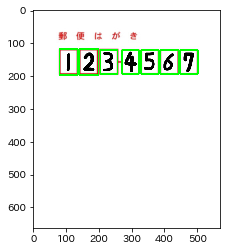

In [25]:
import cv2
import matplotlib.pyplot as plt

# ハガキ画像から郵便番号領域を抽出する関数
def detect_zipno(fname):
    # 画像を読み込む
    img = cv2.imread(fname)
    # 画像のサイズを求める
    h, w = img.shape[:2]
    # ハガキ画像の右上のみ抽出する --- (*1)
    img = img[0:h//2, w//3:]
    
    # 画像を二値化 --- (*2)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (3, 3), 0) 
    im2 = cv2.threshold(gray, 140, 255, cv2.THRESH_BINARY_INV)[1]
    
    # 輪郭を抽出 --- (*3)
    cnts = cv2.findContours(im2, 
        cv2.RETR_LIST,
        cv2.CHAIN_APPROX_SIMPLE)[1]
    
    # 抽出した輪郭を単純なリストに変換--- (*4)
    result = []
    for pt in cnts:
        x, y, w, h = cv2.boundingRect(pt)
        # 大きすぎる小さすぎる領域を除去 --- (*5)
        if not(50 < w < 70): continue
        result.append([x, y, w, h])
    # 抽出した輪郭が左側から並ぶようソート --- (*6)
    result = sorted(result, key=lambda x: x[0])
    # 抽出した輪郭が近すぎるものを除去 --- (*7)
    result2 = []
    lastx = -100
    for x, y, w, h in result:
        if (x - lastx) < 10: continue
        result2.append([x, y, w, h])
        lastx = x
    # 緑色の枠を描画 --- (*8)
    for x, y, w, h in result2:
        cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 3)
    return result2, img

if __name__ == '__main__':
    # ハガキ画像を指定して領域を抽出
    cnts, img = detect_zipno("hagaki1.png")

    # 画面に抽出結果を描画 --- (*7)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.savefig("detect-zip.png", dpi=200)
    plt.show()



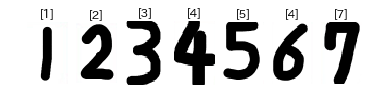

In [26]:
from detect_zip import *
import matplotlib.pyplot as plt

from sklearn.externals import joblib

# 学習済み手書き数字のデータを読込
clf = joblib.load("digits.pkl")

# 画像から領域を読み込む
cnts, img = detect_zipno("hagaki1.png")

# 読み込んだデータをプロット
for i, pt in enumerate(cnts):
    x, y, w, h = pt
    # 枠線の輪郭分だけ小さくする
    x += 8
    y += 8
    w -= 16
    h -= 16
    # 画像データを取り出す
    im2 = img[y:y+h, x:x+w]
    # データを学習済みデータに合わせる
    im2gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY) # グレイスケールに
    im2gray = cv2.resize(im2gray, (8, 8)) # リサイズ
    im2gray = 15 - im2gray // 16 # 白黒反転
    im2gray = im2gray.reshape((-1, 64)) # 一次元に変換
    # データ予測する
    res = clf.predict(im2gray)
    # 画面に出力
    plt.subplot(1, 7, i + 1)
    plt.imshow(im2)
    plt.axis("off")
    plt.title(res)

plt.show()